In [1]:
import pylab as pl
import pandas as pd
import re
import gc
import xgboost as xgb
# import lightgbm as lgb
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict, Counter
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
from scipy.stats import pearsonr
from scipy.sparse import hstack
from multiprocessing import Pool

Folder = '/Users/xinwang/ai/dataset/kaggle/DonorsChoose/'
Ttr = pd.read_csv(Folder + 'train.csv', low_memory=False)
Tts = pd.read_csv(Folder + 'test.csv', low_memory=False)

target = 'project_is_approved'
Ttr['tr'] = 1; Tts['tr'] =0;
Ttr['ts'] =0; Tts['ts'] =0;

T = pd.concat((Ttr, Tts))

T.loc[T.project_essay_4.isnull(), ['project_essay_4','project_essay_2']] = T.loc[
    T.project_essay_4.isnull(), ['project_essay_2','project_essay_4']].values

T[['project_essay_2','project_essay_3']] = T[['project_essay_2','project_essay_3']].fillna('')

T['project_essay_1'] = T.apply(lambda row: ' '.join([row['project_essay_1'], row['project_essay_2']]), axis=1)
T['project_essay_2'] = T.apply(lambda row: ' '.join([row['project_essay_3'], row['project_essay_4']]), axis=1)

T.drop(['project_essay_3','project_essay_4'], axis=1, inplace=True)

T.info()

/Users/xinwang/ai/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 78034
Data columns (total 16 columns):
id                                              260115 non-null object
project_essay_1                                 260115 non-null object
project_essay_2                                 260115 non-null object
project_grade_category                          260115 non-null object
project_is_approved                             182080 non-null float64
project_resource_summary                        260115 non-null object
project_subject_categories                      260115 non-null object
project_subject_subcategories                   260115 non-null object
project_submitted_datetime                      260115 non-null object
project_title                                   260115 non-null object
school_state                                    260115 non-null object
teacher_id                                      260115 non-null object
teacher_number_of_previously_posted_p

In [2]:
R = pd.read_csv(Folder + 'resources.csv', low_memory=False)

print(R.head())

R['priceAll'] = R['quantity'] * R['price']

newR = R.groupby('id').agg({
    'description':'count',
    'quantity':'sum',
    'price':'sum',
    'priceAll':'sum'
}).rename(columns={'description':'items'})

newR['avgPrice'] = newR.priceAll / newR.quantity

num_features = ['items','quantity','price','priceAll','avgPrice']

for func in ['max','min','mean','median']:
    newR = newR.join(R.groupby('id').agg({
        'quantity':func,
        'price':func,
        'priceAll':func
    }).rename(columns={'quantity': func+'quantity',
                       'price': func+'price',
                       'priceAll': func+'priceAll'}).fillna(0))

    num_features += [func+'quantity',func+'price',func+'priceAll']
    
newR = newR.join(R.groupby('id').agg({
    'description': lambda x: ' '.join(x.values.astype(str))
}).rename(columns={'description':'resource_description'}))


T = T.join(newR, on='id')

T['price_category'] = pl.digitize(T.priceAll, [0, 50, 100, 250, 500, 1000, pl.inf])
num_features.append('price_category')

for c in ['quantity','price','priceAll']:
    T['max%s_min%s'%(c,c)] = T['max%s'%c] - T['min%s'%c]
    num_features.append('max%s_min%s'%(c,c))
    
del Ttr, Tts, R, newR
gc.collect();


        id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   
2  p069063  Cory Stories: A Kid's Book About Living With Adhd         1   
3  p069063  Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...         2   
4  p069063  EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...         3   

    price  
0  149.00  
1   14.95  
2    8.45  
3   13.59  
4   24.95  


Index(['id', 'project_essay_1', 'project_essay_2', 'project_grade_category',
       'project_is_approved', 'project_resource_summary',
       'project_subject_categories', 'project_subject_subcategories',
       'project_submitted_datetime', 'project_title', 'school_state',
       'teacher_id', 'teacher_number_of_previously_posted_projects',
       'teacher_prefix', 'tr', 'ts', 'items', 'quantity', 'price', 'priceAll',
       'avgPrice', 'maxquantity', 'maxprice', 'maxpriceAll', 'minquantity',
       'minprice', 'minpriceAll', 'meanquantity', 'meanprice', 'meanpriceAll',
       'medianquantity', 'medianprice', 'medianpriceAll',
       'resource_description', 'price_category'],
      dtype='object')

In [3]:

print(T.columns)

print(T.teacher_prefix.unique())


s_test = T[['id', 'school_state']].groupby('school_state').agg('count')
s_test.head()

Index(['id', 'project_essay_1', 'project_essay_2', 'project_grade_category',
       'project_is_approved', 'project_resource_summary',
       'project_subject_categories', 'project_subject_subcategories',
       'project_submitted_datetime', 'project_title', 'school_state',
       'teacher_id', 'teacher_number_of_previously_posted_projects',
       'teacher_prefix', 'tr', 'ts', 'items', 'quantity', 'price', 'priceAll',
       'avgPrice', 'maxquantity', 'maxprice', 'maxpriceAll', 'minquantity',
       'minprice', 'minpriceAll', 'meanquantity', 'meanprice', 'meanpriceAll',
       'medianquantity', 'medianprice', 'medianpriceAll',
       'resource_description', 'price_category', 'maxquantity_minquantity',
       'maxprice_minprice', 'maxpriceAll_minpriceAll'],
      dtype='object')
['Ms.' 'Mrs.' 'Mr.' 'Teacher' 'Dr.' nan]


,id
school_state,
AK,796
AL,4267
AR,2487
AZ,5200
CA,36418


In [4]:
le = LabelEncoder()

T['teacher_id'] = le.fit_transform(T['teacher_id'])
T['teacher_gender_unknown'] = T.teacher_prefix.apply(lambda x: int(x not in ['Ms.' 'Mrs.' 'Mr.']))

num_features += ['teacher_number_of_previously_posted_projects','teacher_id','teacher_gender_unknown']


statFeatures = []
for col in ['school_state','teacher_id','teacher_prefix','teacher_gender_unknown','project_grade_category',
            'project_subject_categories', 'project_subject_subcategories','teacher_number_of_previously_posted_projects']:
    Stat = T[['id', col]].groupby(col).agg('count').rename(columns={
        'id':col + '_stat'
    })

    Stat /= Stat.sum()
    T = T.join(Stat, on=col)
    
    statFeatures.append(col + '_stat')
    

print(T.columns)
print('-'*50)
print(num_features)

Index(['id', 'project_essay_1', 'project_essay_2', 'project_grade_category',
       'project_is_approved', 'project_resource_summary',
       'project_subject_categories', 'project_subject_subcategories',
       'project_submitted_datetime', 'project_title', 'school_state',
       'teacher_id', 'teacher_number_of_previously_posted_projects',
       'teacher_prefix', 'tr', 'ts', 'items', 'quantity', 'price', 'priceAll',
       'avgPrice', 'maxquantity', 'maxprice', 'maxpriceAll', 'minquantity',
       'minprice', 'minpriceAll', 'meanquantity', 'meanprice', 'meanpriceAll',
       'medianquantity', 'medianprice', 'medianpriceAll',
       'resource_description', 'price_category', 'maxquantity_minquantity',
       'maxprice_minprice', 'maxpriceAll_minpriceAll',
       'teacher_gender_unknown', 'school_state_stat', 'teacher_id_stat',
       'teacher_prefix_stat', 'teacher_gender_unknown_stat',
       'project_grade_category_stat', 'project_subject_categories_stat',
       'project_subject_su

In [5]:
text_columns = ['project_essay_1','project_essay_2','project_resource_summary','resource_description','project_title']

def getSentFeat(s):
    sent = TextBlob(s).sentiment
    return (sent.polarity, sent.subjectivity)

print("Sentiment Analysis")
with Pool(6) as p:
    for col in text_columns:
        temp = pl.array(list(p.map(getSentFeat, T[col])))
        
        T[col + '_pol'] = temp[:,0]
        T[col + '_sub'] = temp[:,1]
        
        num_features += [col + '_pol',col + '_sub']
      
    
    
print('Key words')

KeyChars = ['!', '\?', '@', '#', '\$', '%', '&', '\*', '\(', '\[', '\{', '\|', '-', '_', '=', '\+',
            '\.', ':', ';', ',', '/', '\\\\r', '\\\\t', '\\"', '\.\.\.', 'etc', 'http', 'poor',
            'military', 'traditional', 'charter', 'head start', 'magnet', 'year-round', 'alternative',
            'art', 'book', 'basics', 'computer', 'laptop', 'tablet', 'kit', 'game', 'seat',
            'food', 'cloth', 'hygiene', 'instraction', 'technolog', 'lab', 'equipment',
            'music', 'instrument', 'nook', 'desk', 'storage', 'sport', 'exercise', 'trip', 'visitor',
            'my students', 'our students', 'my class', 'our class']


for col in text_columns:
    for c in KeyChars:
        T[col+'_'+c] = T[col].apply(lambda x:len(re.findall(c, x.lower())))
        num_features.append(col+'_'+c)
        
        
###--------- num of words ---------###    
print('num of words')

for col in text_columns:
    T['n_'+col] = T[col].apply(lambda x: len(x.split()))
    num_features.append('n_'+col)
    
    T['nUpper_'+col] = T[col].apply(lambda x: sum([s.isupper() for s in list(x)]))
    num_features.append('nUpper_'+col)
    

###--------- word tags ------------###
print('word tags')

Tags = ['CC', 'CD', 'DT', 'IN', 'JJ', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 
        'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 
        'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']

def getTagFeat(s):
    d = Counter([t[1] for t in pos_tag(s.split())])
    
    return [d[t] for t in Tags]


print('len.Tags',len(Tags))
d = T['project_resource_summary'].values.astype(str)
for summary in d:
    list_summary = getTagFeat(summary)
    print(list_summary)
    
    break
    

print('start to getTagFeat...')
with Pool(6) as p:
    for col in text_columns:
        temp = pl.array(list(p.map(getTagFeat, T[col])))
        
        for i, t in enumerate(Tags):
            if temp[:,i].sum() ==0:
                continue
            
            T[col +'_' + t] = temp[:,i]
            num_features.append(col +'_' + t)
            

print('common words')
for i,col1 in enumerate(text_columns[:-1]):
    for col2 in text_columns[i+1:]:
        T['%s_%s_common'%(col1, col2)] = T.apply(lambda row: len(
            set(re.split('\W', row[col1].lower())).intersection(
                re.split('\W', row[col2].lower()))), axis=1)
        num_features.append('%s_%s_common'%(col1, col2))
    print('common words progress', i)
        
T.columns

Sentiment Analysis
Key words
num of words
word tags
len.Tags 32
[2, 1, 1, 1, 0, 0, 0, 5, 2, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
start to getTagFeat...
common words
common words progress 0
common words progress 1
common words progress 2
common words progress 3


Index(['id', 'project_essay_1', 'project_essay_2', 'project_grade_category',
       'project_is_approved', 'project_resource_summary',
       'project_subject_categories', 'project_subject_subcategories',
       'project_submitted_datetime', 'project_title',
       ...
       'project_essay_1_project_essay_2_common',
       'project_essay_1_project_resource_summary_common',
       'project_essay_1_resource_description_common',
       'project_essay_1_project_title_common',
       'project_essay_2_project_resource_summary_common',
       'project_essay_2_resource_description_common',
       'project_essay_2_project_title_common',
       'project_resource_summary_resource_description_common',
       'project_resource_summary_project_title_common',
       'resource_description_project_title_common'],
      dtype='object', length=555)

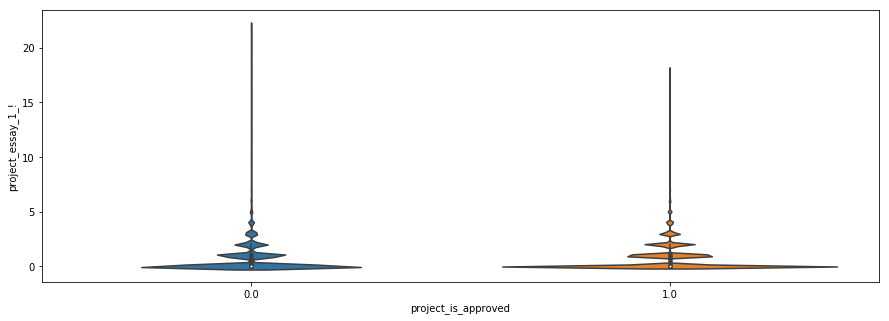

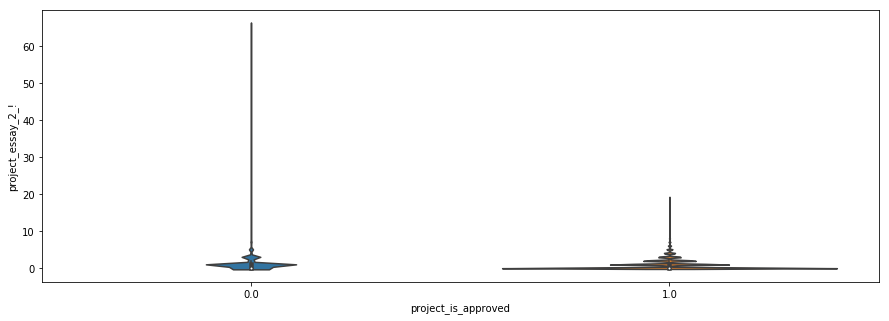

In [6]:
pl.figure(figsize=(15,5))
sns.violinplot(data=T, x=target, y='project_essay_1_!')

pl.figure(figsize=(15,5))
sns.violinplot(data=T, x=target, y='project_essay_2_!')


In [7]:
T.columns

print('len.num_features',len(num_features))

len.num_features 532


In [8]:
date_column = 'project_submitted_datetime'

def getTimeFeatures(T):
    T['year'] = T[date_column].apply(lambda x: x.year)
    T['month'] = T[date_column].apply(lambda x: x.month)
    T['day'] = T[date_column].apply(lambda x: x.day)
    
    T['dow'] = T[date_column].apply(lambda x: x.dayofweek)
    T['hour'] = T[date_column].apply(lambda x: x.hour)
    T['days'] = (T[date_column] - T[date_column].min()).apply(lambda x: x.days)
    
    return T
    
T[date_column] = pd.to_datetime(T[date_column])
T = getTimeFeatures(T)


P_tar = T[T.tr==1][target].mean()
time_features = ['year','month','day','dow','hour','days']
statFeatures = []

for col in time_features:
    Stat = T[['id', col]].groupby(col).agg('count').rename(columns={'id': col + '_stat'})
    Stat /= Stat.sum()
    
    T = T.join(Stat, on=col)
    
    statFeatures.append(col + '_stat')
    
num_features += time_features
num_features += statFeatures

print('len.num_features',len(num_features))

len.num_features 544


In [9]:
T2 = T[num_features + ['id','tr','ts',target]].copy()

x_train = T2[T.tr==1]
y_train = x_train[target].values

n = 4

inx = [pl.randint(0, x_train.shape[0], int(x_train.shape[0]/n)) for k in range(n)]
print(inx[0])


[167264  89292  95764 ... 181245 130241  90550]


In [10]:
Corr = {}
import time

print('start process polynomial features', len(num_features))
for i, c in enumerate(num_features):
    start_time = time.time()
    C1, P1 = pl.nanmean( [pearsonr(y_train[inx[k]], (1+x_train[c].iloc[inx[k]])) for k in range(n)], 0)
    C2, P2 = pl.nanmean( [pearsonr(y_train[inx[k]], 1/(1+x_train[c].iloc[inx[k]])) for k in range(n)], 0)
    
    if P2< P1:
        T2[c] = 1/(1+T2[c])
        Corr[c] = [C2, P2]
    else:
        T2[c] = 1 + T2[c]
        Corr[c] = [C1, P1]

    end_time = time.time()
    if i % 20 == 0:
        print('calculate corr ' + c + ' cost time ', (end_time-start_time))
        
print('Corr.size', len(Corr))

polyCol = []
thrP = 0.01
thrC = 0.02    

for i, c1 in enumerate(num_features[:-1]):
    C1,P1 = Corr[c1]
    
    start_time = time.time()
    
    for c2 in num_features[i+1:]:
        C2, P2 = Corr[c2]
        V = T2[c1] * T2[c2]
        Vtrain = V[T2.tr==1].values
        
        C,P = pl.nanmean([pearsonr(y_train[inx[k]], Vtrain[inx[k]]) for k in range(n)],0)
        
        if P<thrP and (abs(C)-max(abs(C1), abs(C2))>thrC):
            T[c1+'_' +c2+'_poly'] = V
            polyCol.append(c1+'_' +c2+'_poly')
            print('add new feature',c1+'_' +c2+'_poly',len(polyCol))
        else:
            del V, Vtrain
    
    end_time = time.time()
    if i%20 == 0:
        print('poly feature progress ' +str(i)+' cost time',(end_time-start_time),'s')
        print(T.info())

num_features += polyCol
print(len(num_features))


del T2, x_train
gc.collect()

start process polynomial features 544
calculate corr items cost time  0.8743948936462402
calculate corr maxpriceAll_minpriceAll cost time  0.012986183166503906


/Users/xinwang/ai/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/xinwang/ai/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/xinwang/ai/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/xinwang/ai/lib/python3.6/site-packages/scipy/stats/stats.py:3007: RuntimeWarning: invalid value encountered in subtract
  xm, ym = x - mx, y - my
/Users/xinwang/ai/lib/python3.6/site-packages/scipy/stats/stats.py:3008: RuntimeWarning: invalid value encountered in reduce
  r_num = np.add.reduce(xm * ym)


calculate corr project_essay_1_& cost time  0.015505075454711914
calculate corr project_essay_1_http cost time  0.7893660068511963
calculate corr project_essay_1_hygiene cost time  0.013962030410766602
calculate corr project_essay_2_@ cost time  0.7796580791473389
calculate corr project_essay_2_\\t cost time  0.016122817993164062
calculate corr project_essay_2_game cost time  0.7501029968261719
calculate corr project_essay_2_my class cost time  0.016160011291503906
calculate corr project_resource_summary_; cost time  0.02487778663635254
calculate corr project_resource_summary_computer cost time  0.8451430797576904
calculate corr project_resource_summary_trip cost time  0.016251087188720703
calculate corr resource_description_= cost time  0.012666940689086914
calculate corr resource_description_alternative cost time  0.013078927993774414
calculate corr resource_description_desk cost time  0.5957379341125488
calculate corr project_title_\{ cost time  0.017929792404174805
calculate corr p

/Users/xinwang/ai/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice


add new feature resource_description_sub_resource_description_magnet_poly 34
add new feature resource_description_sub_resource_description_art_poly 35
add new feature resource_description_sub_resource_description_kit_poly 36
add new feature resource_description_sub_resource_description_game_poly 37
add new feature resource_description_sub_resource_description_NNPS_poly 38
add new feature resource_description_sub_resource_description_VBG_poly 39
poly feature progress 40 cost time 2.5595250129699707 s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 78034
Columns: 606 entries, id to resource_description_sub_resource_description_VBG_poly
dtypes: datetime64[ns](1), float64(78), int64(516), object(11)
memory usage: 1.2+ GB
None
poly feature progress 60 cost time 2.704896926879883 s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 78034
Columns: 606 entries, id to resource_description_sub_resource_description_VBG_poly
dtypes: datetime64[ns](1), flo

add new feature project_essay_2_CD_project_resource_summary_NNS_poly 72
add new feature project_essay_2_DT_resource_description_VBD_poly 73
add new feature project_essay_2_IN_resource_description_VBD_poly 74
poly feature progress 400 cost time 0.7366640567779541 s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 78034
Columns: 641 entries, id to project_essay_2_IN_resource_description_VBD_poly
dtypes: datetime64[ns](1), float64(113), int64(516), object(11)
memory usage: 1.2+ GB
None
add new feature project_essay_2_NN_resource_description_CD_poly 75
add new feature project_essay_2_VB_resource_description_VBD_poly 76
poly feature progress 420 cost time 0.6673312187194824 s
<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 78034
Columns: 643 entries, id to project_essay_2_VB_resource_description_VBD_poly
dtypes: datetime64[ns](1), float64(115), int64(516), object(11)
memory usage: 1.3+ GB
None
add new feature project_resource_summary_CD_project_e

91

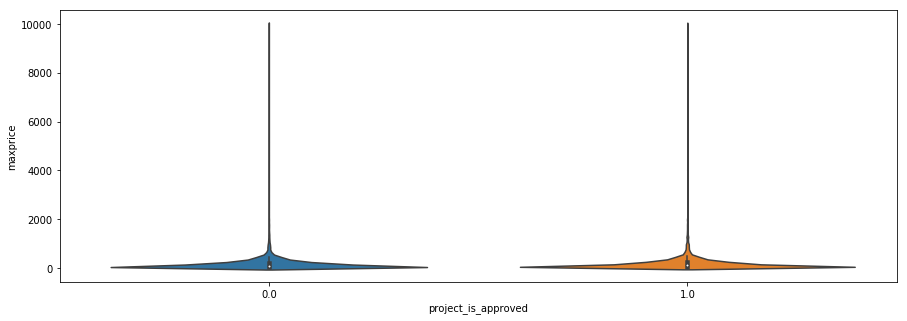

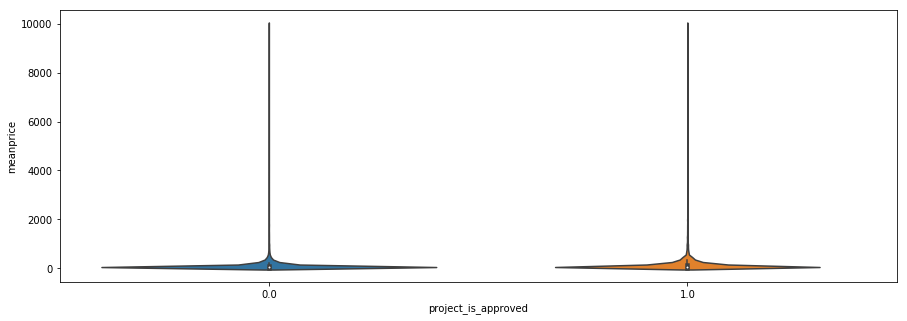

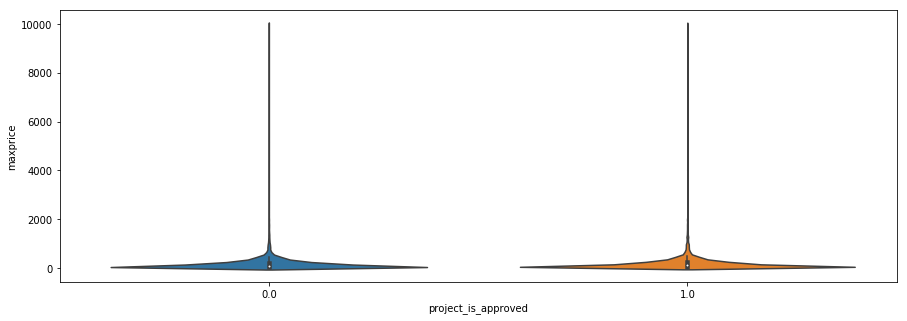

In [11]:
pl.figure(figsize=(15,5)); sns.violinplot(data=T, x=target, y='maxprice')
pl.figure(figsize=(15,5)); sns.violinplot(data=T, x=target, y='meanprice')
pl.figure(figsize=(15,5)); sns.violinplot(data=T, x=target, y='maxprice')

In [12]:
def getCateFeatures(T, col):
    vectorizer = CountVectorizer(binary=True,ngram_range=(1,1),
                                tokenizer = lambda x: [a.strip() for a in x.split(',')])
    return vectorizer.fit_transform(T[col].fillna(''))

X_teacher_prefix = getCateFeatures(T, 'teacher_prefix')
X_school_state = getCateFeatures(T, 'school_state')

X_project_grade_category = getCateFeatures(T, 'project_grade_category')

X_project_subject_categories = getCateFeatures(T, 'project_subject_categories')
X_project_subject_subcategories = getCateFeatures(T, 'project_subject_subcategories')

X_cate = hstack((X_teacher_prefix,X_school_state,X_project_grade_category,X_project_subject_categories,X_project_subject_subcategories))

del X_teacher_prefix,X_school_state,X_project_grade_category,X_project_subject_categories,X_project_subject_subcategories

print('cate features done')

cate features done


In [13]:
T.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260115 entries, 0 to 78034
Columns: 648 entries, id to project_essay_1_project_resource_summary_common_project_essay_2_project_resource_summary_common_poly
dtypes: datetime64[ns](1), float64(120), int64(516), object(11)
memory usage: 1.3+ GB


In [14]:
p = PorterStemmer()

def wordPreProcess(sentence):
    return ' '.join(
        [p.stem(x.lower()) for x in re.split('\W', sentence) if len(x)>=1])

def getTextFeatures(col, max_features=3000, ngrams=(1,2), verbose=True):
    print('start to process data.shape')
    
    vectorizer = CountVectorizer(stop_words=None,
                                preprocessor=wordPreProcess,
                                max_features=max_features,
                                binary=True,
                                ngram_range=ngrams)
    X = vectorizer.fit_transform(T[col])
    
    return X, vectorizer.get_feature_names()

text_columns = ['project_essay_1','project_essay_2','project_resource_summary','resource_description','project_title']
column_2_numoffeature = {
    'project_essay_1':2000,
    'project_essay_2':5000,
    'project_resource_summary':2000,
    'resource_description':3000,
    'project_title':500
}

X_essay_1, essay_1_features = getTextFeatures('project_essay_1', max_features=column_2_numoffeature['project_essay_1'])
X_essay_2, essay_2_features = getTextFeatures('project_essay_2', max_features=column_2_numoffeature['project_essay_2'])

X_summay, summay_features = getTextFeatures('project_resource_summary', max_features=column_2_numoffeature['project_resource_summary'])
X_resource_desc, resource_desc_features = getTextFeatures('resource_description', max_features=column_2_numoffeature['resource_description'])
X_project_title, project_title_features = getTextFeatures('project_title', max_features=column_2_numoffeature['project_title'])

X_text = hstack((X_essay_1,X_essay_2,X_summay,X_resource_desc,X_project_title))

del X_essay_1,X_essay_2,X_summay,X_resource_desc,X_project_title
gc.collect()

print('text features done X_text.shape',X_text.shape)

start to process data.shape
start to process data.shape
start to process data.shape
start to process data.shape
start to process data.shape
text features done X_text.shape (260115, 12500)


In [16]:
from sklearn.preprocessing import StandardScaler

X_numeric = StandardScaler().fit_transform(T[num_features].fillna(0))
X = hstack((X_text, X_cate, X_numeric)).tocsr()

X_train = X[pl.find(T.tr==1), :]
X_test  = X[pl.find(T.ts==1), :]

train_target = T[T.tr==1][target].values
test_data = T[T.ts==1][['id',target]]


Ytest = []
del T, X
gc.collect()

/Users/xinwang/ai/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  
/Users/xinwang/ai/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: The find function was deprecated in version 2.2.
  import sys


21

In [27]:
from keras.layers import Input, Dense, Flatten, concatenate, Dropout, Embedding, SpatialDropout1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def breakInput(X1):
    X2 = []
    i = 0
    for n in [n_essay_1,n_essay_2,n_project_resource_summary,n_resource_desc,n_project_title,X_cate.shape[1], len(num_features)]:
        X2.append(X1[:,i:i+n])
        i += n
        
    return X2


def get_model(hiddenUnits, Drop=0.25, OP=optimizers.Adam()):
    temp = []
    
    inputs_text = []
    
    for n in [n_essay_1,n_essay_2,n_project_resource_summary,n_resource_desc,n_project_title]:
        input_text = Input((n,))
        X_feat = Dropout(Drop)(input_text)
        X_feat = Dense(int(n/100), activation='linear')(X_feat)
        X_feat = Dropout(Drop)(X_feat)
        
        temp.append(X_feat)
        inputs_text.append(input_text)

    
    x_1 = concatenate(temp)
    x_1 = Dense(50, activation='relu')(x_1)
    x_1 = Dropout(Drop)(x_1)
    
    
    input_cate = Input((X_cate.shape[1],))
    x_2 = Embedding(2, 10, input_length=X_cate.shape[1])(input_cate)
    x_2 = SpatialDropout1D(Drop)(x_2)
    x_2 = Flatten()(x_2)
    
    
    input_num = Input((len(num_features),))
    x_3 = Dropout(Drop)(input_num)
    
    x = concatenate([x_1, x_2, x_3])
    
    for hidden in hiddenUnits:
        x = Dense(hidden, activation='relu')(x)
        x = Dropout(Drop)(x)
                    
    output = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs_text + [input_cate,input_num], ouputs=output)
    model.compile(optimizer=OP,
                  loss='binary_crossentropy',
                  metrics='binary_accuracy')
    return model
                    
def train_NN(X_train, X_eval, Target_train, Targe_eval, hiddenUnits=[50,50], Drop=0.5, OP=optimizers.Adam()):
    file_path = 'nn.h5'
    checkpoint = ModelCheckpoint(file_path, monitor='val_loss',verbose=1, save_best_only=True,
                                save_weights_only=True, mode='min')
    early = EarlyStopping(monitor='val_loss', mode='min', patience=6)
                    
    lr_reduced = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,
                                  patience=2,
                                  verbose=2,
                                  epsilon=3e-4,
                                  mode='min')
    model = get_model(hiddenUnits, Drop, OP)
    model.fit(breakInput(X_train), Target_train, validation_data=(breakInput(X_eval), Targe_eval),
             verbose=2,epochs=50, batch_size=1000, callbacks=[early, lr_reduced, checkpoint])
                
    model.load_weights(file_path)
    
    return model
                    
params_xgb = {
    'eta':0.05,
    'max_depth':4,
    'subsample':0.85,
    'colsample_bytree':0.25,
    'min_child_weight':3,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'seed':100,
    'silent':1
}
                    
# import lightgbm as lgb
params_lgb = {
    'boosting_type':'dart',
    'objective':'binary',
    'metric':'auc',
    'max_depth':10,
    'learning_rate':0.05,
    'feature_fraction':0.25,
    'bagging_fraction':0.85,
    'seed':100,
    'verbose':0
}
                    
nCV=1
for i in range(21,22):
    gc.collect()
    X_train,X_eval,Y_train,Y_eval = train_test_split(X_train,train_target,test_size=0.15, random_state=i, stratify=train_target)

#     XGB
    dtrain = xgb.DMatrix(X_train,label=Y_train)
    deval = xgb.DMatrix(X_eval,label=Y_eval)
    watchlist = [(dtrain,'train'),(deval,'eval')]
    model = xgb.train(params_xgb, dtrain, 5000, watchlist, maximize=True, verbose_eval=200, early_stopping_rounds=200)

    Y_eval_predict_1 = model.predict(deval)
    Y_test_predict_1 = model.predict(xgb.DMatrix(X_test))
                    
#     LGB
#     dtrain = lgb.Dataset(X_train,Y_train)
#     deval = lgb.Dataset(X_eval,Y_eval)
#     model = lgb.train(params_lgb, dtrain, num_boost_round=10000, valid_sets=[dtrain,deval], early_stopping_rounds=200,
#                      verbose_eval=200)
                    
#     Y_eval_predict_2 = model.predict(deval)
#     Y_test_predict_2 = model.predict(lgb.Dataset(X_test))
                    
#   NN
    model = train_NN(X_train,X_eval,Y_train,Y_eval, hiddenUnits=[50], Drop=0.5, OP=optimizers.Adam())
    Y_eval_predict_3 = model.predict(breakInput(X_eval)).squeeze()
    Y_test_predict_3 = model.predict(breakInput(X_test)).squeeze()
                    
#     stack
    M = LinearRegression()
    M.fit(pl.array([Y_eval_predict_1, Y_eval_predict_3]).T, Y_eval)
    Ytest.append(M.predict(pl.array(Y_test_predict_1, Y_test_predict_3).T))

[0]	train-auc:0.698511	eval-auc:0.698781
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 200 rounds.
[200]	train-auc:0.802571	eval-auc:0.792484
[400]	train-auc:0.824762	eval-auc:0.802756
[600]	train-auc:0.839722	eval-auc:0.807038
[800]	train-auc:0.851609	eval-auc:0.809162
[1000]	train-auc:0.861835	eval-auc:0.810508
[1200]	train-auc:0.871303	eval-auc:0.811394
[1400]	train-auc:0.879792	eval-auc:0.812341
[1600]	train-auc:0.887358	eval-auc:0.812594
Stopping. Best iteration:
[1506]	train-auc:0.883826	eval-auc:0.812638



TypeError: train_NN() got an unexpected keyword argument 'HL'

In [ ]:
from sklearn.preprocessing import MinMaxScaler

test_data[target] = MinMaxScaler().fit_transform(
    pl.array(Ytest).mean(0).reshape(-1,1))

test_data[['id',target]].to_csv('text_cat_num_xgb_lgb_NN.csv', index=False)